# **SIIM ACR Pneumothorax Segmentation Data**

##Pre-requisites to understand the Business problem

##What is Pneumothorax?


A pneumothorax is a collapsed lung. A pneumothorax occurs when air leaks into the space between your lung and chest wall. This air pushes on the outside of your lung and makes it collapse. Pneumothorax can be a complete lung collapse or a collapse of only a portion of the lung.
Symptoms: Shortness of breath; Chest pain
Risk Factors: Chronic obstructive pulmonary disease

##Business Problem/Problem Statement

Pneumothorax is usually diagnosed by a radiologist on a chest x-ray, and can sometimes be very difficult to confirm. An accurate AI algorithm to detect pneumothorax would be useful in a lot of clinical scenarios. AI could be used to triage chest radiographs for priority interpretation, or to provide a more confident diagnosis for non-radiologists.

##Why use Deep Learning/Machine Learning to solve this problem ?

Going though each of the X-ray images and narrowing down the location of the affected area is very time consuming and a tedious process. Small miscalculations or oversights might cost the patient his/her life. Through the model trained if we can simplify the tasks for the doctors we can reduce the rate of error and probably save many lives.

## Translating the Business Problem to a Deep Learning/Machine Learning Problem

We are expected to build a model which :


*   Classifies wheather the patient has Pneumothorax or not
*   After classifying the xray we must segment/detect the location which is affected for the doctors/Proffesionals to look further into



Metric:

The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. 

####Constraints:

1. No Hard Latency requirments

#Understanding the Data given

There is a folder named Pneumothorax in which there are the three following subfolders:

*   dicom-images-train

*   dicom-images-test
*   train-rle.csv





The images are in the form of .dcm . The train-rle.csv contains the image id for the train data along with the images mask values which were compressed using RLE.

#Exploratory Data Analysis

In [76]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import os 
import datetime as dt
from datetime import datetime
#!pip install pydicom
import pydicom as dicom
from tqdm.notebook import tqdm
from glob import glob
import pandas as pd

In [2]:
from zipfile import ZipFile
zip_file = ZipFile('archive.zip','r')
zip_file.extractall()


In [314]:
#reading all dcm files into train and text
train = sorted(glob("pneumothorax/dicom-images-train/*/*/*.dcm")) #There is an image after 2 subfolders . Rather than manually typing the entire path we are using glob to access the image with ease
test = sorted(glob("pneumothorax/dicom-images-test/*/*/*.dcm"))

#reading the csv

dataset = pd.read_csv("pneumothorax/train-rle.csv", delimiter=",")

In [317]:
print("There are {} train files ".format(len(train)))
print("There are {} test files ".format(len(test)))
print("the csv with the labels: -1 means no Pneumothorax, otherwise there is an encoding for the mask of the region affected by Pneumothorax")
dataset.head()

There are 10712 train files 
There are 1377 test files 
the csv with the labels: -1 means no Pneumothorax, otherwise there is an encoding for the mask of the region affected by Pneumothorax


,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002...
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...


In [24]:
#Reading the metadata of a random image to understand the data present
sample = dicom.dcmread(train[0])
print(sample)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.10001.1517875220.930580
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.10001.1517875220.930580
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      



*   There is a lot of information present in the form of metadata. 

*   The Patient's age,sex and view position might help us in giving insight towards the people affected and various other factors which we will explore further
*   For all the images the body part examined is chest and the photometric interpretation used is Monochrome2. These are constant for all images hence we do not need to explore them in more depth


*   List item



In [319]:
missing_images=0
train_df=[]
for i in tqdm(train):
  sample=dicom.dcmread(i) #reading each image
  train={}
  train["UID"]=sample.SOPInstanceUID 
  try: #try and except to avoid throwing an error in case any file is missing
    encoded_pixels = dataset[dataset["ImageId"] == train["UID"]].values[0][1] #We are checking wheather each image(from the train) present has been mapped to the csv file given . 
    train["EncodedPixels"]=encoded_pixels
  except:
    missing_images=missing_images+1 #if the image details are not present in the csv that means that the file is missing
  train["Age"] = sample.PatientAge 
  train["Sex"] = sample.PatientSex
  train["ViewPosition"] = sample.ViewPosition
  train["path"] = "pneumothorax/dicom-images-train/" + sample.StudyInstanceUID + "/" + sample.SeriesInstanceUID + "/" + sample.SOPInstanceUID + ".dcm" #saving the path in csv for further reference
  train_df.append(train)

patients_train = pd.DataFrame(train_df,columns=["UID", "EncodedPixels", "Age", "Sex","ViewPosition","path"])

In [320]:
print("There are {} images missing based on the given CSV file".format(missing_images))
patients_train['Age']=patients_train['Age'].astype(float)
patients_train.head()

There are 37 images missing based on the given CSV file


,UID,EncodedPixels,Age,Sex,ViewPosition,path
0,1.2.276.0.7230010.3.1.4.8323329.1000.151787516...,-1,38.0,M,PA,pneumothorax/dicom-images-train/1.2.276.0.7230...
1,1.2.276.0.7230010.3.1.4.8323329.10000.15178752...,-1,10.0,F,AP,pneumothorax/dicom-images-train/1.2.276.0.7230...
2,1.2.276.0.7230010.3.1.4.8323329.10001.15178752...,-1,50.0,F,AP,pneumothorax/dicom-images-train/1.2.276.0.7230...
3,1.2.276.0.7230010.3.1.4.8323329.10002.15178752...,-1,68.0,F,AP,pneumothorax/dicom-images-train/1.2.276.0.7230...
4,1.2.276.0.7230010.3.1.4.8323329.10003.15178752...,-1,65.0,M,AP,pneumothorax/dicom-images-train/1.2.276.0.7230...


## Checking the distribution of The labels

****************************************************************************************************
The number of patients who are not diagnosed with Pneumothorax are 8296
The number of patients who are diagnosed with Pneumothorax are 2416
****************************************************************************************************


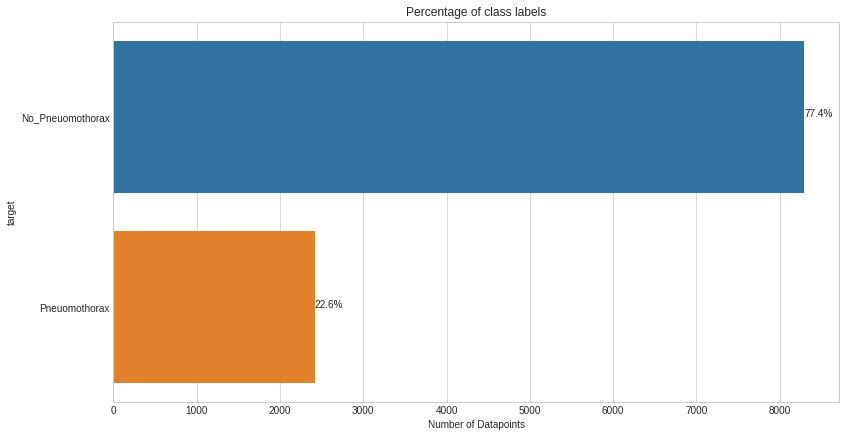

In [321]:
pneumothorax=0
No_pneumothorax=0
target=[]
for i in patients_train['EncodedPixels']:
  if str(i).strip()=="-1":
    No_pneumothorax=No_pneumothorax+1
    target.append("No_Pneuomothorax")
  else:
    pneumothorax=pneumothorax+1
    target.append("Pneuomothorax")
Data=patients_train.copy()
Data['target']=target

print('*'*100)
print("The number of patients who are not diagnosed with Pneumothorax are",No_pneumothorax)
print("The number of patients who are diagnosed with Pneumothorax are",pneumothorax)
print('*'*100)
plt.figure(figsize=(13,7))
ax=sns.countplot(y='target',data=Data)
plt.title('Percentage of class labels')
plt.xlabel('Number of Datapoints')

total = len(Data['target'])
for p in ax.patches:
  percentage = '{:.1f}%'.format(100 * p.get_width()/total)
  x = p.get_x() + p.get_width() + 0.02
  y = p.get_y() + p.get_height()/2
  ax.annotate(percentage, (x, y))

plt.show()



*   The train data is imbalanced but nothing of major concern as we can perform various augumentation techniques to overcome this problem.



## Distribution of All age groups across the given Dataset

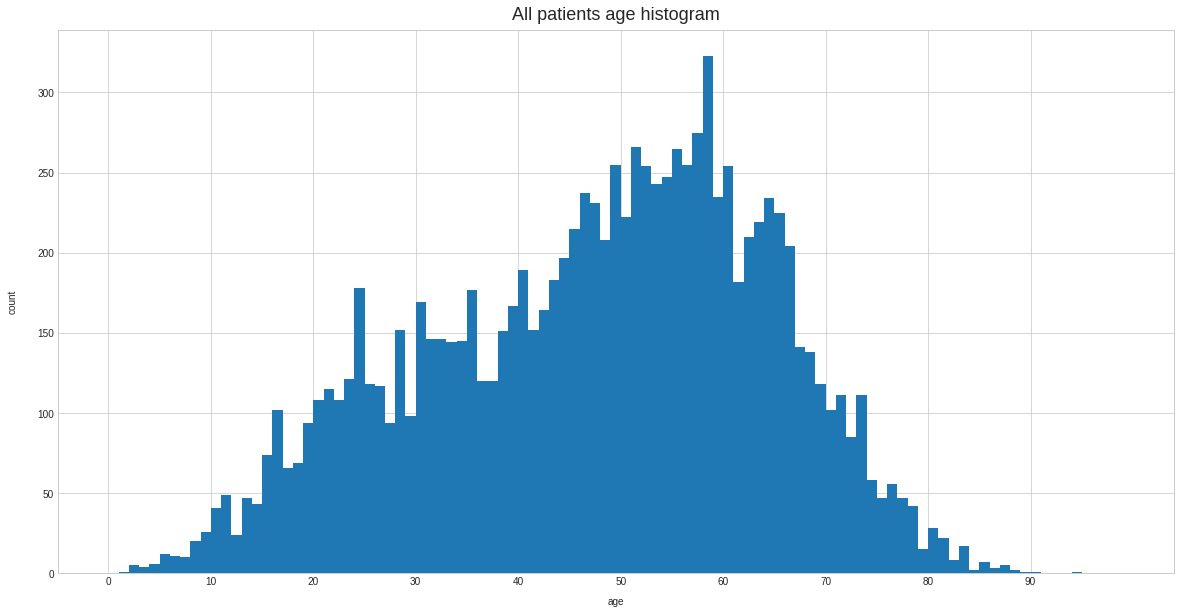

In [245]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,10))
plt.hist(sorted(Data['Age']), bins=[i for i in range(100)])
plt.title("All patients age histogram", fontsize=18, pad=10)
plt.xlabel("age", labelpad=10)
plt.xticks([i*10 for i in range(10)])
plt.ylabel("count", labelpad=20)
plt.show()



1.   Even though we cannot be completely sure we can understand that most of the data given in the datset consists of people from various age groups .
2.   Many people present in this dataset are between the age 45-55



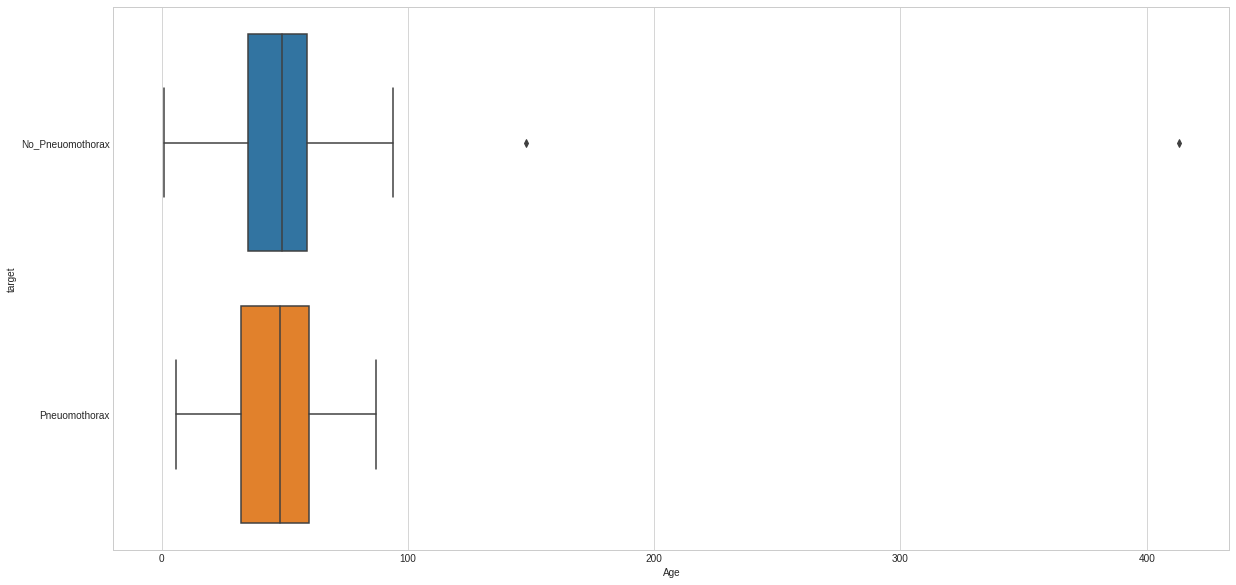

In [170]:
plt.figure(figsize=(20,10))
sns.boxplot(x=Data['Age'],y=Data['target'])

From the box plot we can observe two outliers with respect to the age.
Let us look into those outliers.

In [324]:
print("The valued of the age which is an outlier is",sorted(Data['Age'])[-1])
print("The valued of the age which is an outlier is",sorted(Data['Age'])[-2])

The valued of the age which is an outlier is 413.0
The valued of the age which is an outlier is 148.0





1.   Having an age of 413 and 148 is very unlikely.
2.   They are definitely values which have been entered by mistake 





In [325]:
print(np.median(Data['Age']))
print(np.mean(Data['Age']))

49.0
47.075056011949215




*  We can observe that the impact of the outlier age is very less as there is a very small difference between its mean and median



## Distribution of All age groups for the patients diagnosed with Pneumothorax

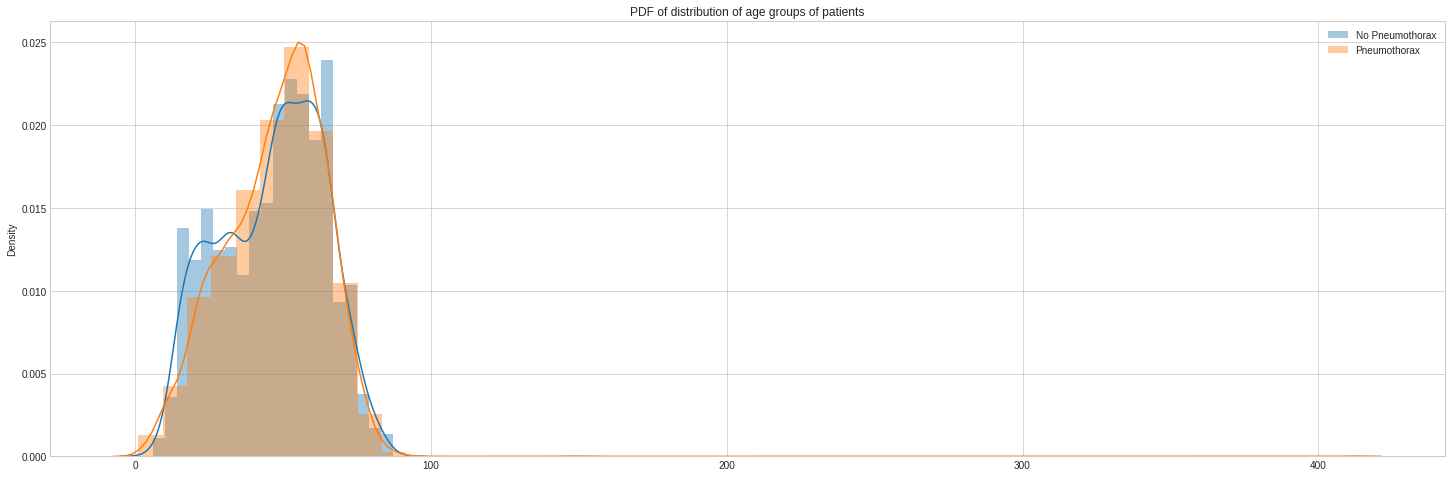

In [248]:
plt.figure(figsize=(25,8))
sns.distplot(sorted(Data[Data["EncodedPixels"] != ' -1']['Age']),kde=True,label="No Pneumothorax")
sns.distplot(sorted(Data[Data["EncodedPixels"] == ' -1']['Age']),kde=True,label="Pneumothorax")
plt.title("PDF of distribution of age groups of patients")
plt.legend()
plt.show()

Observation:

*   There is a high overlap in the PDF's of the ages of patients with an without Pneumothorax
*   So we can tell that age alone does not have any role to play in determining wheather someone has Pneumothorax or not



## Anlaysis based on the Patients gender and Age 

The number of Male diagnosed with Pneumothorax are  1349
The number of Female diagnosed with Pneumothorax are  1067
****************************************************************************************************


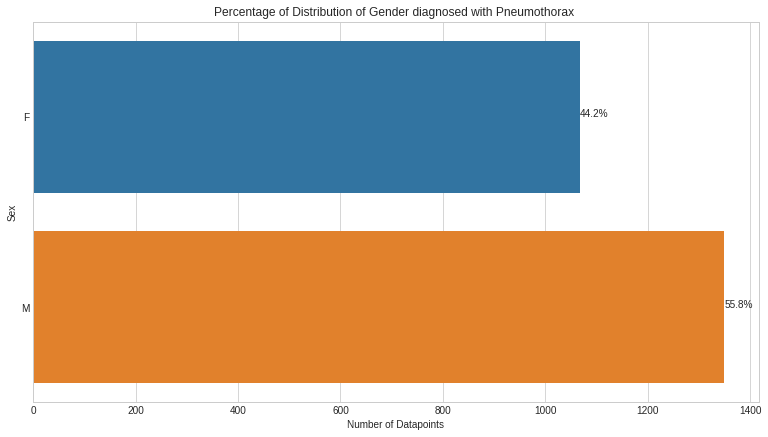

In [200]:
m=0
f=0
with_pneumonia=Data[Data["EncodedPixels"] != ' -1']['Sex'] #Patients Gender where the patient has been diagnosed with Pneumothorax 
with_pneumonia=pd.DataFrame(with_pneumonia)
with_pneumonia.columns=["Sex"]
for i in with_pneumonia["Sex"]:
  if i=='M':
    m=m+1
  else:
    f=f+1

print("The number of Male diagnosed with Pneumothorax are ",m)
print("The number of Female diagnosed with Pneumothorax are ",f)
print("*"*100)
plt.figure(figsize=(13,7))
ax=sns.countplot(y='Sex',data=with_pneumonia)
plt.title('Percentage of Distribution of Gender diagnosed with Pneumothorax ')
plt.xlabel('Number of Datapoints')

total = len(with_pneumonia)
for p in ax.patches:
  percentage = '{:.1f}%'.format(100 * p.get_width()/total)
  x = p.get_x() + p.get_width() + 0.02
  y = p.get_y() + p.get_height()/2
  ax.annotate(percentage, (x, y))

plt.show()



*   Out of all the patients diagnosed with Pneumothorax 56.8 % of them are male patients and 44.2 % of them are female patients.
*   Before making conclusions that male are more vulnerable to the disease let us make sure of the percentage of male and female who have been affected by the disease from the train dataset



In [327]:
Data["Sex"].value_counts()

M    5903
F    4809
Name: Sex, dtype: int64

In [209]:
print((1067/4809)*100)
print((1349/5903)*100)

22.18756498232481
22.85278671861765




*   Out of all the males mentioned in the dataset 22.85 % of them have been diagnosed with Pneumothorax
*   Out of all the females mentioned in the dataset 22.187 % of them have been diagnosed with Pneumothorax

*   Based on all the above observations we can tell that Men and Women are equally affected by the disease.
*   But male have a sightly higher chance of having the disease than female.





Let us dive deep into the affect of the disease on the individual gender with respect to their age

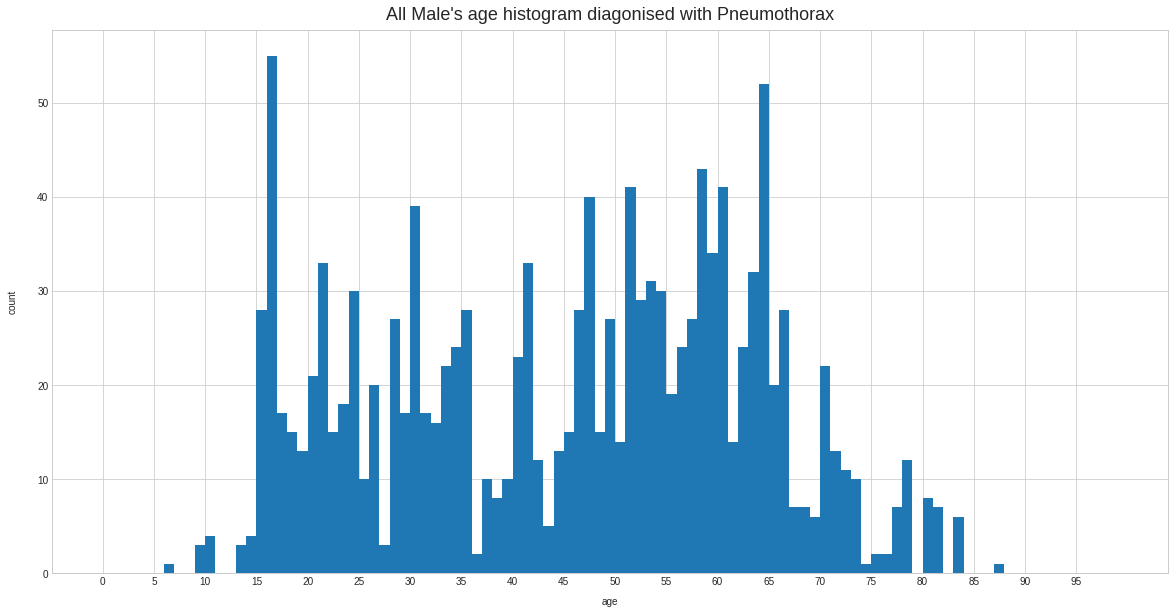

In [249]:
pneumothorax = Data.loc[Data['EncodedPixels'] != ' -1' ] #Data of patients affected with Pneumothorax
male_pneumothorax=pneumonia.loc[pneumothorax['Sex'] =='M']  #Patients who have been affected Pneumothorax and are male
female_pneumothorax=pneumothorax.loc[pneumothorax['Sex'] =='F'] #Patients who have been affected Pneumothorax and are female
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,10))
plt.hist(sorted(male_pneumothorax['Age']), bins=[i for i in range(100)])

plt.title("All Male's age histogram diagonised with Pneumothorax", fontsize=18, pad=10)
plt.xlabel("age", labelpad=10)
plt.xticks([i*5 for i in range(20)])
plt.ylabel("count", labelpad=20)
plt.show()

Observations:

*   It's quit unfortunate that children(Male) of the age 16 and 17  suffer from Pneumonothorax more than people above the age of 65 and many adults
*   There are very few people above the age of 65 who suffer from the disease.



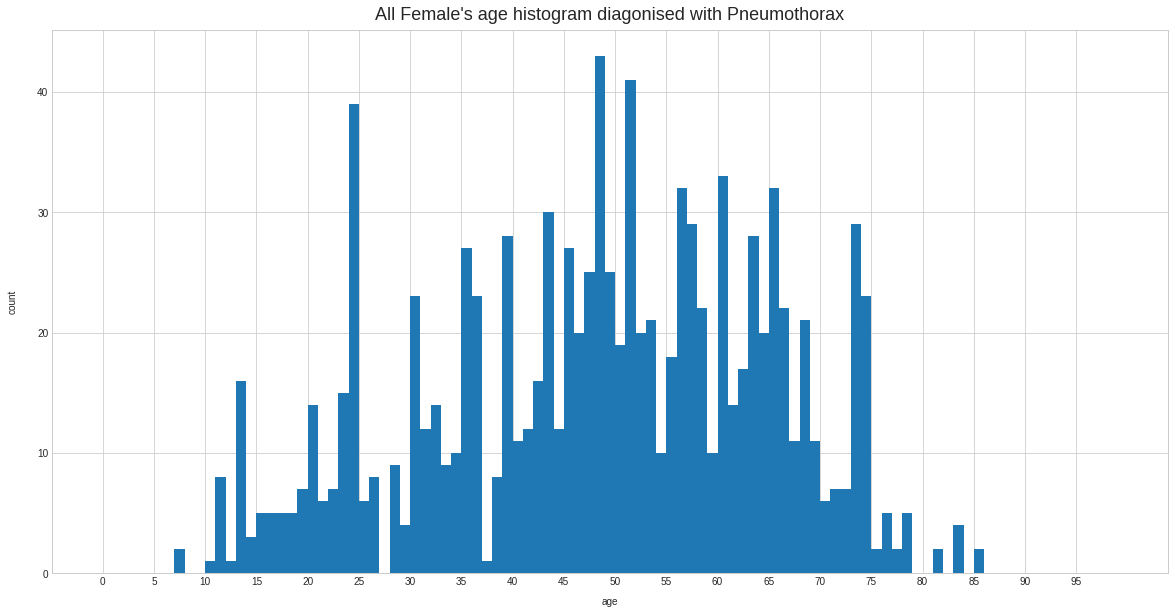

In [250]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,10))
plt.hist(sorted(female_pneumothorax['Age']), bins=[i for i in range(100)])
plt.title("All Female's age histogram diagonised with Pneumothorax", fontsize=18, pad=10)
plt.xlabel("age", labelpad=10)
plt.xticks([i*5 for i in range(20)])
plt.ylabel("count", labelpad=20)
plt.show()

Observations:

*   There are very few children from the female population who suffer from the disease unlike the male population.
* There are very few women above the age of 75 who are suffering from the disease . 



Let us observe the PDF of both the Male(Age) and Female(Age) who are affected by Pnuemothorax  

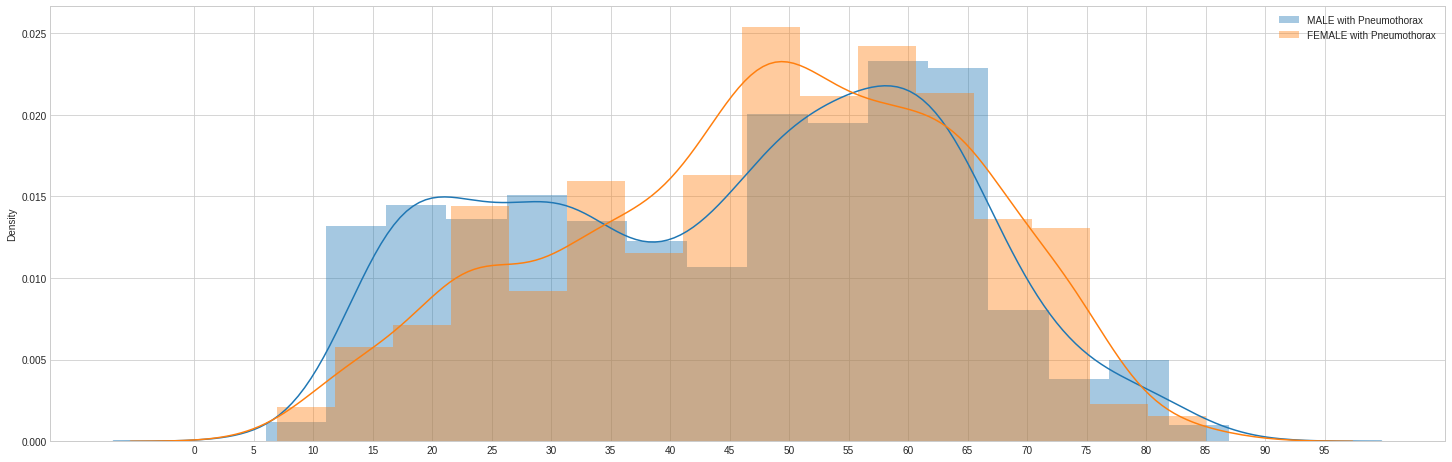

In [233]:
plt.figure(figsize=(25,8))
sns.distplot(sorted(male_pneumothorax['Age']),kde=True,label="MALE with Pneumothorax")
sns.distplot(sorted(female_pneumothorax['Age']),kde=True,label="FEMALE with Pneumothorax")
plt.xticks([i*5 for i in range(20)])
plt.legend()
plt.show()

There is a large overlap between the PDF's of both the Male and Female age who are affected by the disease. But there are few key observations:

*   There are more Male patients than Female patients between the age group of 7-33 affected by Pneumuthorax
*   There are more Female patients than Male patients between the age group of 34-55 affected by Pneumuthorax

* There are more older women than older men suffering from Pneumothorax(65+) 





##Analyzing the View Position and Mask values

Before analysing the view postion let us understand a few new terms:
 

The view position can be AP or PA. These refer to the way of x-ray in the body

AP XRAY : An X-ray picture in which the beams pass from front-to-back (anteroposterior).

PA XRAY: An X-ray source is positioned so that the x-ray beam enters through the posterior (back) aspect of the chest and exits out of the anterior (front) aspect, where the beam is detected.

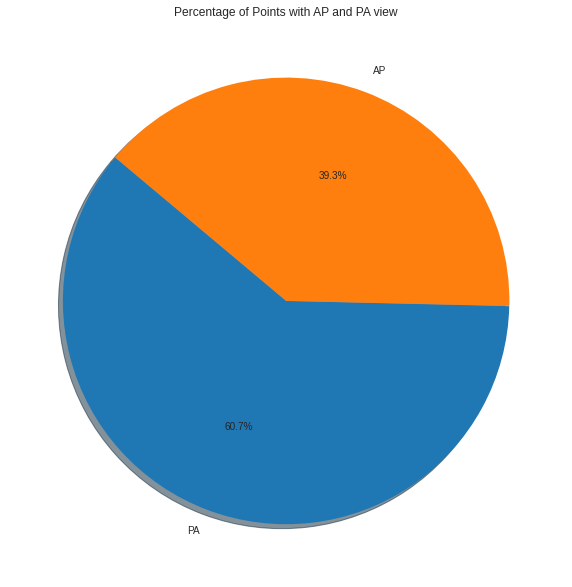

In [270]:

View = ['PA', 'AP'] 
  
data = [len(Data[Data['ViewPosition']=='PA']),len(Data[Data['ViewPosition']=='AP'])] 
  
# Creating plot 
fig = plt.figure(figsize =(10,20)) 
plt.title("Percentage of Points with AP and PA view")
plt.pie(data, labels = View,autopct='%1.1f%%', shadow=True,startangle=140,explode=(0.001, 0)) 
  
# show plot 
plt.show() 



*   39.3 % of the Xray images are AP -Xray 
*   60.7 % of the Xray images are PA -Xray



Plot any 3 random Xray with their masks 

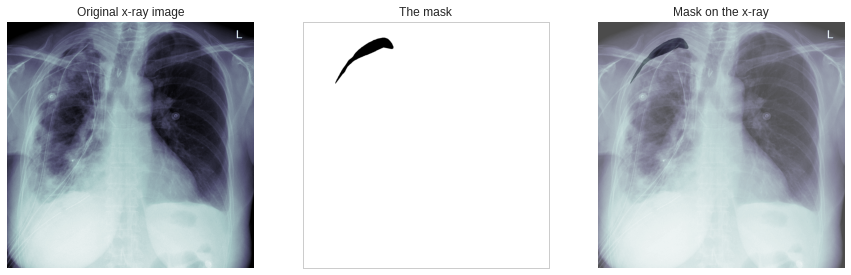

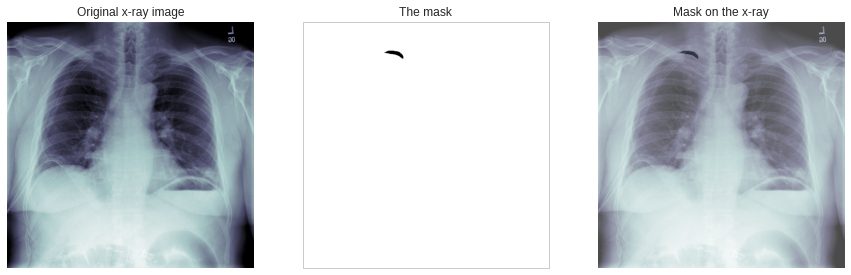

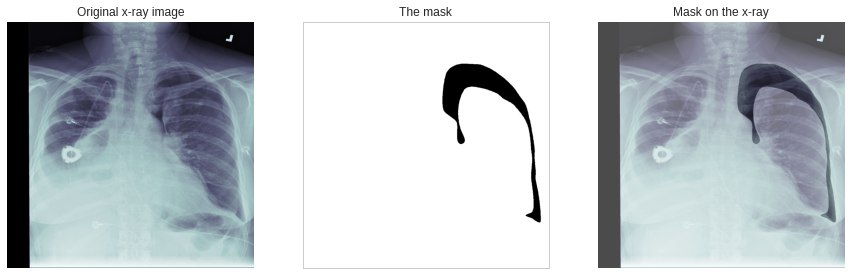

In [329]:
import mask_functions #this .py has been provided by the host of the competition to convert the RLE values to a mask and vice versa
with_pneumothorax = patients_train[patients_train["EncodedPixels"] != ' -1'] #patients with Pnuemothorax

mask = mask_functions.rle2mask(with_pneumothorax.values[30][1], 1024, 1024).T #We have to transpose the masks for them to properly overlap with the xray image
img = dicom.read_file(with_pneumothorax.values[30][-1]).pixel_array #reading the original image 

fig = plt.figure(figsize=(15, 10))
a = fig.add_subplot(1, 3, 1)
plt.imshow(img, cmap='bone') #original x-ray
a.set_title("Original x-ray image")
plt.grid(False)
plt.axis("off")

a = fig.add_subplot(1, 3, 2)
imgplot = plt.imshow(mask, cmap='binary')

a.set_title("The mask")
plt.grid(False)
plt.xticks([])
plt.yticks([])

a = fig.add_subplot(1, 3, 3)
plt.imshow(img, cmap='bone')
plt.imshow(mask, cmap='binary', alpha=0.3)
a.set_title("Mask on the x-ray")

plt.axis("off")

plt.grid(False)

mask = mask_functions.rle2mask(with_pneumothorax.values[6][1], 1024, 1024).T #We have to transpose the masks for them to properly overlap with the xray image
img = dicom.read_file(with_pneumothorax.values[6][-1]).pixel_array #reading the original image 

fig = plt.figure(figsize=(15, 10))
a = fig.add_subplot(1, 3, 1)
plt.imshow(img, cmap='bone') #original x-ray
a.set_title("Original x-ray image")
plt.grid(False)
plt.axis("off")

a = fig.add_subplot(1, 3, 2)
imgplot = plt.imshow(mask, cmap='binary')

a.set_title("The mask")
plt.grid(False)
plt.xticks([])
plt.yticks([])

a = fig.add_subplot(1, 3, 3)
plt.imshow(img, cmap='bone')
plt.imshow(mask, cmap='binary', alpha=0.3)
a.set_title("Mask on the x-ray")

plt.axis("off")

plt.grid(False)


mask = mask_functions.rle2mask(with_pneumothorax.values[3][1], 1024, 1024).T #We have to transpose the masks for them to properly overlap with the xray image
img = dicom.read_file(with_pneumothorax.values[3][-1]).pixel_array #reading the original image 

fig = plt.figure(figsize=(15, 10))
a = fig.add_subplot(1, 3, 1)
plt.imshow(img, cmap='bone') #original x-ray
a.set_title("Original x-ray image")
plt.grid(False)
plt.axis("off")

a = fig.add_subplot(1, 3, 2)
imgplot = plt.imshow(mask, cmap='binary')

a.set_title("The mask")
plt.grid(False)
plt.xticks([])
plt.yticks([])

a = fig.add_subplot(1, 3, 3)
plt.imshow(img, cmap='bone')
plt.imshow(mask, cmap='binary', alpha=0.3)
a.set_title("Mask on the x-ray")

plt.axis("off")

plt.grid(False)




*   We have convertesd the RLE values to masks and have overlapped them on the xray images

*   We can observe that out of the three images plotted the affected area with pneumothorax is very small and one of them is quite significant .
*   Let us see if this has anything to do with PA and AP



In [330]:
with_pneumothorax = patients_train[patients_train["EncodedPixels"] != ' -1'] #patients with Pnuemothorax
PA_pneumothorax=with_pneumothorax[with_pneumothorax['ViewPosition']=='PA']#patients with Pnuemothorax and view position as PA
AP_pneumothorax=with_pneumothorax[with_pneumothorax['ViewPosition']=='AP']#patients with Pnuemothorax and view position as AP

In [342]:
PA_view_non_zero_pixel_count=[]
for p in tqdm(PA_pneumothorax.values):
    try:
        mask = rle2mask(p[1], 1024, 1024)
        pixels = np.count_nonzero(mask)#number of non zero pixel values after getting the mask from the RLE
        PA_view_non_zero_pixel_count.append(pixels)
    except:
      pass
        
        


In [343]:
AP_view_non_zero_pixel_count=[]
for p in tqdm(AP_pneumothorax.values):
    try:
        mask = rle2mask(p[1], 1024, 1024)
        pixels = np.count_nonzero(mask)#number of non zero pixel values after getting the mask from the RLE
        AP_view_non_zero_pixel_count.append(pixels)
    except:
      pass

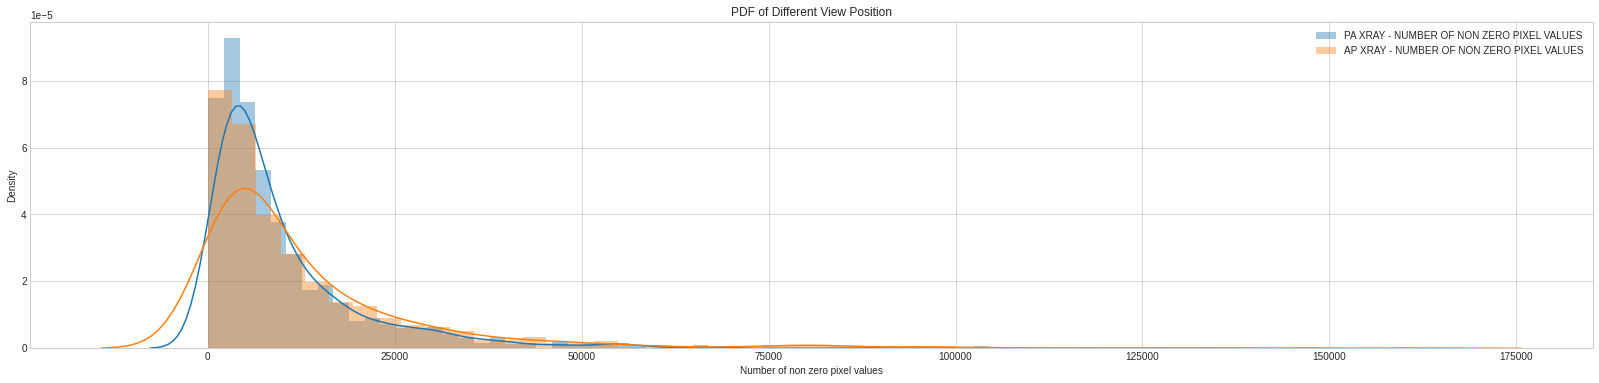

In [360]:
fig=plt.figure(figsize=(28,6))
plt.title("PDF of Different View Position")
sns.distplot(PA_view_non_zero_pixel_count,kde=True,label="PA XRAY - NUMBER OF NON ZERO PIXEL VALUES")
sns.distplot(AP_view_non_zero_pixel_count,kde=True,label="AP XRAY - NUMBER OF NON ZERO PIXEL VALUES")
plt.xlabel("Number of non zero pixel values")
plt.legend()



*   Both the PA view and AP view have very less number of non zero pixel values

*   Having more nummber of non zero pixel value means that the mask is large which implies that the area affected by Pneumothorax is more.
*  The PA view has less amount of non zero pixel values than AP Xray view


*   There are more number of non zero pixel values for the PA Xray than the AP Xray view.

*   This implies that there are more number of larger masks(More affected area) detected with the PA Xray view .





##Preprocessing
1) Will try different preprocessing techniques
2) Based on the mentors sugggestions I shall proceed forward.